<a href="https://colab.research.google.com/github/samanthajmichael/machine_learning/blob/main/notebooks/FinBERT_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install tdqm

In [2]:
import pandas as pd
def load_github_data(url):
    """
    Load data from GitHub raw content URL
    Example URL: https://raw.githubusercontent.com/samanthajmichael/machine_learning/main/data/complaints.csv
    """
    return pd.read_csv(url)

In [3]:
url = "https://raw.githubusercontent.com/samanthajmichael/machine_learning/main/data/complaints.csv"
df = pd.read_csv(url)

In [4]:
df = df.copy(deep=True)
df = df.rename(columns={'Date received': 'Date', 'Consumer complaint narrative': 'Complaint'})
df = df.loc[(df['Product']=='Bank account or service') |
            (df['Product']=='Checking or savings account') |
            (df['Product']=='Money transfers') |
            (df['Product']=='Money transfer, virtual currency, or money service')]
df = df[['Date', 'Product', 'Complaint']]
df = df.set_index(pd.to_datetime(df['Date'], format='mixed'))
df.drop(['Date'], axis=1, inplace=True)

In [5]:
print("Data shape:", df.shape)
print("\nSample of preprocessed data:")
print(df.head())

Data shape: (20163, 2)

Sample of preprocessed data:
                                Product  \
Date                                      
2022-08-22  Checking or savings account   
2024-11-25  Checking or savings account   
2023-10-31  Checking or savings account   
2022-10-18  Checking or savings account   
2023-11-08  Checking or savings account   

                                                    Complaint  
Date                                                           
2022-08-22  On XX/XX/2022 I moved {$500.00} from my XXXX X...  
2024-11-25  I had XXXX accounts opened on Wells Fargo and ...  
2023-10-31  I was the victim of false charges to my accoun...  
2022-10-18  I received four emails on XX/XX/XXXX about a W...  
2023-11-08  On XX/XX/, I reached out to Wells Fargo in reg...  


In [6]:
df.head()

,Product,Complaint
Date,,
2022-08-22,Checking or savings account,On XX/XX/2022 I moved {$500.00} from my XXXX X...
2024-11-25,Checking or savings account,I had XXXX accounts opened on Wells Fargo and ...
2023-10-31,Checking or savings account,I was the victim of false charges to my accoun...
2022-10-18,Checking or savings account,I received four emails on XX/XX/XXXX about a W...
2023-11-08,Checking or savings account,"On XX/XX/, I reached out to Wells Fargo in reg..."


In [7]:
def preprocess_text(text):
    if pd.isna(text):
        return text

    # Remove specific identifiers and noise
    text = re.sub(r'Wells\s*\.*\s*Fargo|W\s*\.*\s*F\s*\.*|xxx+|\d+', '', text, flags=re.IGNORECASE)

    # Normalize whitespace
    text = ' '.join(text.split())

    return text

In [18]:
import torch
import numpy as np
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import AutoTokenizer, BertConfig, BertModel, BertPreTrainedModel
from torch.utils.data import Dataset, DataLoader
from transformers.optimization import get_linear_schedule_with_warmup
import torch.nn as nn
import torch.optim
from tqdm import tqdm
import pkg_resources
import re
import os

# Model Definition
class FinBertSentimentRegression(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.regressor = nn.Sequential(
            nn.Linear(config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Tanh() # Contrains the output layer to [-1,1]
        )
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        regression_output = self.regressor(pooled_output)

        loss = None
        if labels is not None:
            # MSE Loss with labels contrained to [-1, 1]
            labels = torch.clamp(labels, min=-1, max=1)
            loss_fct = nn.MSELoss()
            loss = loss_fct(regression_output.view(-1), labels.view(-1))
        else:
            loss = torch.mean(regression_output)

        return loss, regression_output

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    @classmethod
    def load_model(cls, model_path, config):
        model = cls(config)
        model.load_state_dict(torch.load(model_path, weights_only=True, map_location='cpu'))
        return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = BertConfig.from_pretrained("ProsusAI/finbert", num_labels=1)
model = FinBertSentimentRegression.from_pretrained("ProsusAI/finbert", config=config)
model.to(device)

class ComplaintDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx]) if isinstance(self.texts, pd.Series) else str(self.texts[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten()
        }

def analyze_complaints(df, test_size=0.2, batch_size=16, learning_rate=2e-5, num_epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    checkpoint_dir = '/content/checkpoint'  # Colab-specific path
    checkpoint_path = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')

    try:
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
            print(f"Created checkpoint directory at: {os.path.abspath(checkpoint_dir)}")
    except Exception as e:
        print(f"Error creating checkpoint directory: {e}")
        raise

    processed_texts = df['Complaint'].apply(lambda x: preprocess_text(x) if pd.notna(x) else x)
    valid_mask = processed_texts.notna() & (processed_texts != '')
    processed_texts = processed_texts[valid_mask]

    dates = df[valid_mask].index
    texts = processed_texts

    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    config = BertConfig.from_pretrained("ProsusAI/finbert", num_labels=1)
    model = FinBertSentimentRegression.from_pretrained("ProsusAI/finbert", config=config)
    model.to(device)

    texts_train, texts_test, dates_train, dates_test = train_test_split(
        texts, dates, test_size=test_size, random_state=42
    )

    train_dataset = ComplaintDataset(texts_train, tokenizer=tokenizer)
    test_dataset = ComplaintDataset(texts_test, tokenizer=tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_loader) * num_epochs
    )
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint.get('epoch', 0) + 1
        print(f"Resuming from epoch {start_epoch}")

    model.train()
    for epoch in range(start_epoch, num_epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)

            loss, _ = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Average Loss: {avg_loss:.4f}")

    def process_dataloader(loader, dates):
        predictions = []
        texts_processed = []
        losses = []

        model.eval()
        with torch.no_grad():
            for batch in tqdm(loader, desc="Processing"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)

                loss, outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids
                )

                predictions.extend(outputs.cpu().numpy().flatten())
                texts_processed.extend(batch['text'])
                if loss is not None:
                    losses.append(loss.item())

        results_df = pd.DataFrame({
            'processed_text': texts_processed,
            'sentiment_score': predictions,
        }, index=dates)

        results_df['severity'] = pd.cut(
            results_df['sentiment_score'],
            bins=5,
            labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
        )

        return results_df, np.mean(losses) if losses else 0

    train_results, train_loss = process_dataloader(train_loader, dates_train)
    test_results, test_loss = process_dataloader(test_loader, dates_test)

    monthly_metrics = pd.concat([
      train_results.groupby(pd.Grouper(freq='M'))['sentiment_score'].agg(['mean', 'std', 'count']),
      test_results.groupby(pd.Grouper(freq='M'))['sentiment_score'].agg(['mean', 'std', 'count'])
    ]).sort_index()

    metrics = {
    'train_loss': train_loss,
    'test_loss': test_loss,
    'train_mse': mean_squared_error(train_results['sentiment_score'], [0] * len(train_results)),
    'test_mse': mean_squared_error(test_results['sentiment_score'], [0] * len(test_results))
    }

    # Save most recent epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_mse': metrics['train_mse'],
        'test_mse': metrics['test_mse']
    }, checkpoint_path)

    return train_results, test_results, monthly_metrics, metrics

Some weights of FinBertSentimentRegression were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['regressor.0.bias', 'regressor.0.weight', 'regressor.3.bias', 'regressor.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# # For Colab to local Windows
from google.colab import files

# # Save temporarily in Colab
temp_path = '/content/finbert_sentiment_regression_model'
model.save_model(temp_path)

# # # Download to local machine
# files.download('finbert_sentiment_regression_model')

# print("Model downloaded - please move file to:")
# print(r"C:\Users\saman\Documents\WF Project\finbert_sentiment_regression_model")

In [ ]:
# # Load - must move model to the colab environment first
# loaded_model = FinBertSentimentRegression.load_model('/content/finbert_sentiment_regression_model', config)

In [19]:
# Run analysis
train_results, test_results, monthly_metrics, metrics = analyze_complaints(df)

# Save results to CSV
train_results.to_csv('train_results.csv')
test_results.to_csv('test_results.csv')
monthly_metrics.to_csv('monthly_metrics.csv')

# Save metrics to CSV
pd.DataFrame.from_dict(metrics, orient='index', columns=['value']).to_csv('model_metrics.csv')

# Print summary statistics
print("\nModel Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nMonthly Metrics Sample:")
print(monthly_metrics.head())

Some weights of FinBertSentimentRegression were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['regressor.0.bias', 'regressor.0.weight', 'regressor.3.bias', 'regressor.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████| 1009/1009 [11:54<00:00,  1.41it/s]


Average Loss: -0.9749


Epoch 2/3: 100%|██████████| 1009/1009 [11:52<00:00,  1.42it/s]


Average Loss: -0.9999


Epoch 3/3: 100%|██████████| 1009/1009 [11:53<00:00,  1.41it/s]


Average Loss: -1.0000


Processing: 100%|██████████| 253/253 [00:57<00:00,  4.41it/s]
<ipython-input-18-8693c1bdf633>:208: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_results.groupby(pd.Grouper(freq='M'))['sentiment_score'].agg(['mean', 'std', 'count']),
<ipython-input-18-8693c1bdf633>:209: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_results.groupby(pd.Grouper(freq='M'))['sentiment_score'].agg(['mean', 'std', 'count'])



Model Metrics:
train_loss: -1.0000
test_loss: -1.0000
train_mse: 1.0000
test_mse: 1.0000

Monthly Metrics Sample:
                mean           std  count
Date                                     
2015-03-31 -0.999986  5.937844e-08     12
2015-03-31 -0.999986  3.441276e-08      4
2015-04-30 -0.999986  7.699040e-08     34
2015-04-30 -0.999986  0.000000e+00     13
2015-05-31 -0.999986  6.813023e-08     50


In [21]:
import torch
import numpy as np
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import AutoTokenizer, BertConfig, BertModel, BertPreTrainedModel
from torch.utils.data import Dataset, DataLoader
from transformers.optimization import get_linear_schedule_with_warmup
import torch.nn as nn
import torch.optim
from tqdm import tqdm
import pkg_resources
import re
import os

def analyze_full_dataset(df):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Checkpointing setup with error handling
    try:
        checkpoint_dir = '/content/checkpoint_full_dataset'
        checkpoint_path = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
            print(f"Created checkpoint directory at: {os.path.abspath(checkpoint_dir)}")
    except Exception as e:
        print(f"Error creating checkpoint directory: {e}")
        raise

    # Data preprocessing
    processed_texts = df['Complaint'].apply(lambda x: preprocess_text(x) if pd.notna(x) else x)
    valid_mask = processed_texts.notna() & (processed_texts != '')
    dates = df[valid_mask].index
    texts = processed_texts[valid_mask]

    # Model setup
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    config = BertConfig.from_pretrained("ProsusAI/finbert", num_labels=1)
    model = FinBertSentimentRegression.from_pretrained("ProsusAI/finbert", config=config)
    model.to(device)

    # Dataset and dataloader setup
    dataset = ComplaintDataset(texts, tokenizer=tokenizer)
    dataloader = DataLoader(dataset, batch_size=16)

    # Initialize or load checkpoint
    predictions = []
    texts_processed = []
    start_batch = 0

    if os.path.exists(checkpoint_path):
        try:
            print(f"Loading checkpoint from: {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path)
            predictions = checkpoint.get('predictions', [])
            texts_processed = checkpoint.get('texts_processed', [])
            start_batch = checkpoint.get('batch', 0)
            print(f"Resuming from batch {start_batch} with {len(predictions)} predictions")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Starting from beginning...")

    # Process batches
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Processing")):
            # Skip already processed batches
            if batch_idx < start_batch:
                continue

            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)

                _, outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids
                )

                batch_predictions = outputs.cpu().numpy().flatten()
                batch_texts = batch['text']

                predictions.extend(batch_predictions)
                texts_processed.extend(batch_texts)

                # Save checkpoint every 10 batches
                if (batch_idx + 1) % 10 == 0:
                    try:
                        print(f"\nSaving checkpoint at batch {batch_idx}")
                        torch.save({
                            'batch': batch_idx + 1,
                            'predictions': predictions,
                            'texts_processed': texts_processed
                        }, checkpoint_path)
                        print(f"Successfully saved checkpoint. Processed {len(predictions)} samples so far")
                    except Exception as e:
                        print(f"Error saving checkpoint at batch {batch_idx}: {e}")

            except Exception as e:
                print(f"Error processing batch {batch_idx}: {e}")
                continue

    # Create final results
    try:
        results_df = pd.DataFrame({
            'processed_text': texts_processed,
            'sentiment_score': predictions,
        }, index=dates[:len(predictions)])  # Ensure index matches data length

        results_df['severity'] = pd.cut(
            results_df['sentiment_score'],
            bins=5,
            labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
        )

        # Save final results
        results_path = os.path.join(checkpoint_dir, 'full_dataset_results.csv')
        results_df.to_csv(results_path)
        print(f"\nSaved final results to: {results_path}")

        # Save final checkpoint
        torch.save({
            'batch': len(dataloader),
            'predictions': predictions,
            'texts_processed': texts_processed,
            'completed': True
        }, checkpoint_path)
        print("Saved final checkpoint")

        return results_df

    except Exception as e:
        print(f"Error creating final results: {e}")
        raise

In [22]:
# Run analysis on full dataset
full_results = analyze_full_dataset(df)

Created checkpoint directory at: /content/checkpoint_full_dataset


Some weights of FinBertSentimentRegression were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['regressor.0.bias', 'regressor.0.weight', 'regressor.3.bias', 'regressor.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing:   1%|          | 10/1261 [00:02<04:15,  4.90it/s]


Saving checkpoint at batch 9
Successfully saved checkpoint. Processed 160 samples so far


Processing:   2%|▏         | 20/1261 [00:04<04:15,  4.86it/s]


Saving checkpoint at batch 19
Successfully saved checkpoint. Processed 320 samples so far


Processing:   2%|▏         | 31/1261 [00:06<04:09,  4.93it/s]


Saving checkpoint at batch 29
Successfully saved checkpoint. Processed 480 samples so far


Processing:   3%|▎         | 40/1261 [00:08<04:09,  4.89it/s]


Saving checkpoint at batch 39
Successfully saved checkpoint. Processed 640 samples so far


Processing:   4%|▍         | 50/1261 [00:10<04:15,  4.75it/s]


Saving checkpoint at batch 49
Successfully saved checkpoint. Processed 800 samples so far


Processing:   5%|▍         | 60/1261 [00:12<04:26,  4.51it/s]


Saving checkpoint at batch 59
Successfully saved checkpoint. Processed 960 samples so far


Processing:   6%|▌         | 70/1261 [00:14<04:06,  4.84it/s]


Saving checkpoint at batch 69
Successfully saved checkpoint. Processed 1120 samples so far


Processing:   6%|▋         | 80/1261 [00:16<04:05,  4.80it/s]


Saving checkpoint at batch 79
Successfully saved checkpoint. Processed 1280 samples so far


Processing:   7%|▋         | 90/1261 [00:18<04:03,  4.81it/s]


Saving checkpoint at batch 89
Successfully saved checkpoint. Processed 1440 samples so far


Processing:   8%|▊         | 100/1261 [00:20<04:03,  4.77it/s]


Saving checkpoint at batch 99
Successfully saved checkpoint. Processed 1600 samples so far


Processing:   9%|▊         | 110/1261 [00:22<04:02,  4.75it/s]


Saving checkpoint at batch 109
Successfully saved checkpoint. Processed 1760 samples so far


Processing:  10%|▉         | 120/1261 [00:24<04:09,  4.58it/s]


Saving checkpoint at batch 119
Successfully saved checkpoint. Processed 1920 samples so far


Processing:  10%|█         | 130/1261 [00:26<04:09,  4.53it/s]


Saving checkpoint at batch 129
Successfully saved checkpoint. Processed 2080 samples so far


Processing:  11%|█         | 140/1261 [00:29<03:56,  4.74it/s]


Saving checkpoint at batch 139
Successfully saved checkpoint. Processed 2240 samples so far


Processing:  12%|█▏        | 150/1261 [00:31<03:56,  4.70it/s]


Saving checkpoint at batch 149
Successfully saved checkpoint. Processed 2400 samples so far


Processing:  13%|█▎        | 160/1261 [00:33<03:55,  4.68it/s]


Saving checkpoint at batch 159
Successfully saved checkpoint. Processed 2560 samples so far


Processing:  13%|█▎        | 170/1261 [00:35<03:53,  4.68it/s]


Saving checkpoint at batch 169
Successfully saved checkpoint. Processed 2720 samples so far


Processing:  14%|█▍        | 180/1261 [00:37<04:00,  4.50it/s]


Saving checkpoint at batch 179
Successfully saved checkpoint. Processed 2880 samples so far


Processing:  15%|█▌        | 190/1261 [00:39<04:12,  4.25it/s]


Saving checkpoint at batch 189
Successfully saved checkpoint. Processed 3040 samples so far


Processing:  16%|█▌        | 200/1261 [00:41<03:51,  4.58it/s]


Saving checkpoint at batch 199
Successfully saved checkpoint. Processed 3200 samples so far


Processing:  17%|█▋        | 210/1261 [00:43<03:47,  4.62it/s]


Saving checkpoint at batch 209
Successfully saved checkpoint. Processed 3360 samples so far


Processing:  17%|█▋        | 220/1261 [00:45<03:47,  4.58it/s]


Saving checkpoint at batch 219
Successfully saved checkpoint. Processed 3520 samples so far


Processing:  18%|█▊        | 230/1261 [00:48<03:48,  4.51it/s]


Saving checkpoint at batch 229
Successfully saved checkpoint. Processed 3680 samples so far


Processing:  19%|█▉        | 240/1261 [00:50<03:53,  4.38it/s]


Saving checkpoint at batch 239
Successfully saved checkpoint. Processed 3840 samples so far


Processing:  20%|█▉        | 250/1261 [00:52<04:02,  4.16it/s]


Saving checkpoint at batch 249
Successfully saved checkpoint. Processed 4000 samples so far


Processing:  21%|██        | 260/1261 [00:54<03:41,  4.52it/s]


Saving checkpoint at batch 259
Successfully saved checkpoint. Processed 4160 samples so far


Processing:  21%|██▏       | 270/1261 [00:56<03:41,  4.47it/s]


Saving checkpoint at batch 269
Successfully saved checkpoint. Processed 4320 samples so far


Processing:  22%|██▏       | 280/1261 [00:58<03:40,  4.44it/s]


Saving checkpoint at batch 279
Successfully saved checkpoint. Processed 4480 samples so far


Processing:  23%|██▎       | 290/1261 [01:01<03:42,  4.37it/s]


Saving checkpoint at batch 289
Successfully saved checkpoint. Processed 4640 samples so far


Processing:  24%|██▍       | 300/1261 [01:03<03:46,  4.24it/s]


Saving checkpoint at batch 299
Successfully saved checkpoint. Processed 4800 samples so far


Processing:  25%|██▍       | 310/1261 [01:05<04:01,  3.94it/s]


Saving checkpoint at batch 309
Successfully saved checkpoint. Processed 4960 samples so far


Processing:  25%|██▌       | 320/1261 [01:07<03:34,  4.40it/s]


Saving checkpoint at batch 319
Successfully saved checkpoint. Processed 5120 samples so far


Processing:  26%|██▌       | 330/1261 [01:09<03:30,  4.43it/s]


Saving checkpoint at batch 329
Successfully saved checkpoint. Processed 5280 samples so far


Processing:  27%|██▋       | 340/1261 [01:12<03:28,  4.42it/s]


Saving checkpoint at batch 339
Successfully saved checkpoint. Processed 5440 samples so far


Processing:  28%|██▊       | 350/1261 [01:14<03:28,  4.36it/s]


Saving checkpoint at batch 349
Successfully saved checkpoint. Processed 5600 samples so far


Processing:  29%|██▊       | 360/1261 [01:16<03:39,  4.11it/s]


Saving checkpoint at batch 359
Successfully saved checkpoint. Processed 5760 samples so far


Processing:  29%|██▉       | 370/1261 [01:18<03:41,  4.02it/s]


Saving checkpoint at batch 369
Successfully saved checkpoint. Processed 5920 samples so far


Processing:  30%|███       | 380/1261 [01:20<03:23,  4.34it/s]


Saving checkpoint at batch 379
Successfully saved checkpoint. Processed 6080 samples so far


Processing:  31%|███       | 390/1261 [01:23<03:23,  4.28it/s]


Saving checkpoint at batch 389
Successfully saved checkpoint. Processed 6240 samples so far


Processing:  32%|███▏      | 400/1261 [01:25<03:20,  4.29it/s]


Saving checkpoint at batch 399
Successfully saved checkpoint. Processed 6400 samples so far


Processing:  33%|███▎      | 410/1261 [01:27<03:18,  4.30it/s]


Saving checkpoint at batch 409
Successfully saved checkpoint. Processed 6560 samples so far


Processing:  33%|███▎      | 420/1261 [01:29<03:28,  4.04it/s]


Saving checkpoint at batch 419
Successfully saved checkpoint. Processed 6720 samples so far


Processing:  34%|███▍      | 430/1261 [01:32<03:39,  3.79it/s]


Saving checkpoint at batch 429
Successfully saved checkpoint. Processed 6880 samples so far


Processing:  35%|███▍      | 440/1261 [01:34<03:12,  4.27it/s]


Saving checkpoint at batch 439
Successfully saved checkpoint. Processed 7040 samples so far


Processing:  36%|███▌      | 450/1261 [01:36<03:08,  4.29it/s]


Saving checkpoint at batch 449
Successfully saved checkpoint. Processed 7200 samples so far


Processing:  36%|███▋      | 460/1261 [01:38<03:07,  4.27it/s]


Saving checkpoint at batch 459
Successfully saved checkpoint. Processed 7360 samples so far


Processing:  37%|███▋      | 470/1261 [01:40<03:06,  4.25it/s]


Saving checkpoint at batch 469
Successfully saved checkpoint. Processed 7520 samples so far


Processing:  38%|███▊      | 480/1261 [01:43<03:17,  3.96it/s]


Saving checkpoint at batch 479
Successfully saved checkpoint. Processed 7680 samples so far


Processing:  39%|███▉      | 490/1261 [01:45<03:24,  3.78it/s]


Saving checkpoint at batch 489
Successfully saved checkpoint. Processed 7840 samples so far


Processing:  40%|███▉      | 500/1261 [01:47<03:02,  4.18it/s]


Saving checkpoint at batch 499
Successfully saved checkpoint. Processed 8000 samples so far


Processing:  40%|████      | 510/1261 [01:49<03:04,  4.06it/s]


Saving checkpoint at batch 509
Successfully saved checkpoint. Processed 8160 samples so far


Processing:  41%|████      | 520/1261 [01:52<03:00,  4.11it/s]


Saving checkpoint at batch 519
Successfully saved checkpoint. Processed 8320 samples so far


Processing:  42%|████▏     | 530/1261 [01:54<02:58,  4.10it/s]


Saving checkpoint at batch 529
Successfully saved checkpoint. Processed 8480 samples so far


Processing:  43%|████▎     | 540/1261 [01:56<03:11,  3.76it/s]


Saving checkpoint at batch 539
Successfully saved checkpoint. Processed 8640 samples so far


Processing:  44%|████▎     | 550/1261 [01:59<02:59,  3.96it/s]


Saving checkpoint at batch 549
Successfully saved checkpoint. Processed 8800 samples so far


Processing:  44%|████▍     | 560/1261 [02:01<02:51,  4.08it/s]


Saving checkpoint at batch 559
Successfully saved checkpoint. Processed 8960 samples so far


Processing:  45%|████▌     | 570/1261 [02:03<02:49,  4.08it/s]


Saving checkpoint at batch 569
Successfully saved checkpoint. Processed 9120 samples so far


Processing:  46%|████▌     | 580/1261 [02:05<02:48,  4.04it/s]


Saving checkpoint at batch 579
Successfully saved checkpoint. Processed 9280 samples so far


Processing:  47%|████▋     | 590/1261 [02:08<02:47,  4.01it/s]


Saving checkpoint at batch 589
Successfully saved checkpoint. Processed 9440 samples so far


Processing:  48%|████▊     | 600/1261 [02:10<03:02,  3.62it/s]


Saving checkpoint at batch 599
Successfully saved checkpoint. Processed 9600 samples so far


Processing:  48%|████▊     | 610/1261 [02:12<02:47,  3.88it/s]


Saving checkpoint at batch 609
Successfully saved checkpoint. Processed 9760 samples so far


Processing:  49%|████▉     | 620/1261 [02:15<02:39,  4.01it/s]


Saving checkpoint at batch 619
Successfully saved checkpoint. Processed 9920 samples so far


Processing:  50%|████▉     | 630/1261 [02:17<02:39,  3.96it/s]


Saving checkpoint at batch 629
Successfully saved checkpoint. Processed 10080 samples so far


Processing:  51%|█████     | 640/1261 [02:19<02:34,  4.01it/s]


Saving checkpoint at batch 639
Successfully saved checkpoint. Processed 10240 samples so far


Processing:  52%|█████▏    | 650/1261 [02:22<02:34,  3.95it/s]


Saving checkpoint at batch 649
Successfully saved checkpoint. Processed 10400 samples so far


Processing:  52%|█████▏    | 660/1261 [02:24<02:53,  3.46it/s]


Saving checkpoint at batch 659
Successfully saved checkpoint. Processed 10560 samples so far


Processing:  53%|█████▎    | 670/1261 [02:26<02:31,  3.91it/s]


Saving checkpoint at batch 669
Successfully saved checkpoint. Processed 10720 samples so far


Processing:  54%|█████▍    | 680/1261 [02:29<02:29,  3.89it/s]


Saving checkpoint at batch 679
Successfully saved checkpoint. Processed 10880 samples so far


Processing:  55%|█████▍    | 689/1261 [02:31<02:04,  4.60it/s]


Saving checkpoint at batch 689


Processing:  55%|█████▍    | 690/1261 [02:31<02:44,  3.47it/s]

Successfully saved checkpoint. Processed 11040 samples so far


Processing:  56%|█████▌    | 700/1261 [02:33<02:37,  3.55it/s]


Saving checkpoint at batch 699
Successfully saved checkpoint. Processed 11200 samples so far


Processing:  56%|█████▌    | 709/1261 [02:35<02:05,  4.40it/s]


Saving checkpoint at batch 709


Processing:  56%|█████▋    | 710/1261 [02:36<02:39,  3.45it/s]

Successfully saved checkpoint. Processed 11360 samples so far


Processing:  57%|█████▋    | 720/1261 [02:38<02:21,  3.82it/s]


Saving checkpoint at batch 719
Successfully saved checkpoint. Processed 11520 samples so far


Processing:  58%|█████▊    | 730/1261 [02:40<02:17,  3.88it/s]


Saving checkpoint at batch 729
Successfully saved checkpoint. Processed 11680 samples so far


Processing:  59%|█████▊    | 740/1261 [02:43<02:14,  3.86it/s]


Saving checkpoint at batch 739
Successfully saved checkpoint. Processed 11840 samples so far


Processing:  59%|█████▉    | 750/1261 [02:45<02:13,  3.83it/s]


Saving checkpoint at batch 749
Successfully saved checkpoint. Processed 12000 samples so far


Processing:  60%|██████    | 760/1261 [02:47<02:10,  3.85it/s]


Saving checkpoint at batch 759
Successfully saved checkpoint. Processed 12160 samples so far


Processing:  61%|██████    | 769/1261 [02:49<01:49,  4.51it/s]


Saving checkpoint at batch 769


Processing:  61%|██████    | 770/1261 [02:50<02:23,  3.43it/s]

Successfully saved checkpoint. Processed 12320 samples so far


Processing:  62%|██████▏   | 780/1261 [02:52<02:05,  3.82it/s]


Saving checkpoint at batch 779
Successfully saved checkpoint. Processed 12480 samples so far


Processing:  63%|██████▎   | 790/1261 [02:54<02:02,  3.84it/s]


Saving checkpoint at batch 789
Successfully saved checkpoint. Processed 12640 samples so far


Processing:  63%|██████▎   | 800/1261 [02:57<02:00,  3.83it/s]


Saving checkpoint at batch 799
Successfully saved checkpoint. Processed 12800 samples so far


Processing:  64%|██████▍   | 810/1261 [02:59<01:57,  3.84it/s]


Saving checkpoint at batch 809
Successfully saved checkpoint. Processed 12960 samples so far


Processing:  65%|██████▍   | 819/1261 [03:01<01:37,  4.55it/s]


Saving checkpoint at batch 819


Processing:  65%|██████▌   | 820/1261 [03:01<02:09,  3.41it/s]

Successfully saved checkpoint. Processed 13120 samples so far


Processing:  66%|██████▌   | 829/1261 [03:04<01:38,  4.40it/s]


Saving checkpoint at batch 829


Processing:  66%|██████▌   | 830/1261 [03:04<02:09,  3.34it/s]

Successfully saved checkpoint. Processed 13280 samples so far


Processing:  67%|██████▋   | 840/1261 [03:06<01:51,  3.78it/s]


Saving checkpoint at batch 839
Successfully saved checkpoint. Processed 13440 samples so far


Processing:  67%|██████▋   | 850/1261 [03:09<01:48,  3.78it/s]


Saving checkpoint at batch 849
Successfully saved checkpoint. Processed 13600 samples so far


Processing:  68%|██████▊   | 860/1261 [03:11<01:47,  3.72it/s]


Saving checkpoint at batch 859
Successfully saved checkpoint. Processed 13760 samples so far


Processing:  69%|██████▉   | 870/1261 [03:13<01:43,  3.78it/s]


Saving checkpoint at batch 869
Successfully saved checkpoint. Processed 13920 samples so far


Processing:  70%|██████▉   | 879/1261 [03:15<01:25,  4.48it/s]


Saving checkpoint at batch 879


Processing:  70%|██████▉   | 880/1261 [03:16<01:54,  3.32it/s]

Successfully saved checkpoint. Processed 14080 samples so far


Processing:  71%|███████   | 890/1261 [03:18<01:42,  3.61it/s]


Saving checkpoint at batch 889
Successfully saved checkpoint. Processed 14240 samples so far


Processing:  71%|███████▏  | 900/1261 [03:21<01:36,  3.73it/s]


Saving checkpoint at batch 899
Successfully saved checkpoint. Processed 14400 samples so far


Processing:  72%|███████▏  | 910/1261 [03:23<01:34,  3.70it/s]


Saving checkpoint at batch 909
Successfully saved checkpoint. Processed 14560 samples so far


Processing:  73%|███████▎  | 920/1261 [03:25<01:33,  3.64it/s]


Saving checkpoint at batch 919
Successfully saved checkpoint. Processed 14720 samples so far


Processing:  74%|███████▍  | 930/1261 [03:28<01:33,  3.56it/s]


Saving checkpoint at batch 929
Successfully saved checkpoint. Processed 14880 samples so far


Processing:  74%|███████▍  | 939/1261 [03:30<01:15,  4.27it/s]


Saving checkpoint at batch 939


Processing:  75%|███████▍  | 940/1261 [03:30<01:42,  3.14it/s]

Successfully saved checkpoint. Processed 15040 samples so far


Processing:  75%|███████▌  | 950/1261 [03:33<01:26,  3.61it/s]


Saving checkpoint at batch 949
Successfully saved checkpoint. Processed 15200 samples so far


Processing:  76%|███████▌  | 960/1261 [03:35<01:23,  3.59it/s]


Saving checkpoint at batch 959
Successfully saved checkpoint. Processed 15360 samples so far


Processing:  77%|███████▋  | 970/1261 [03:37<01:19,  3.66it/s]


Saving checkpoint at batch 969
Successfully saved checkpoint. Processed 15520 samples so far


Processing:  78%|███████▊  | 980/1261 [03:40<01:17,  3.63it/s]


Saving checkpoint at batch 979
Successfully saved checkpoint. Processed 15680 samples so far


Processing:  78%|███████▊  | 989/1261 [03:42<01:02,  4.35it/s]


Saving checkpoint at batch 989


Processing:  79%|███████▊  | 990/1261 [03:42<01:25,  3.15it/s]

Successfully saved checkpoint. Processed 15840 samples so far


Processing:  79%|███████▉  | 1000/1261 [03:45<01:13,  3.56it/s]


Saving checkpoint at batch 999
Successfully saved checkpoint. Processed 16000 samples so far


Processing:  80%|████████  | 1010/1261 [03:47<01:10,  3.57it/s]


Saving checkpoint at batch 1009
Successfully saved checkpoint. Processed 16160 samples so far


Processing:  81%|████████  | 1020/1261 [03:50<01:06,  3.63it/s]


Saving checkpoint at batch 1019
Successfully saved checkpoint. Processed 16320 samples so far


Processing:  82%|████████▏ | 1030/1261 [03:52<01:04,  3.59it/s]


Saving checkpoint at batch 1029
Successfully saved checkpoint. Processed 16480 samples so far


Processing:  82%|████████▏ | 1039/1261 [03:54<00:49,  4.48it/s]


Saving checkpoint at batch 1039


Processing:  82%|████████▏ | 1040/1261 [03:54<01:10,  3.15it/s]

Successfully saved checkpoint. Processed 16640 samples so far


Processing:  83%|████████▎ | 1049/1261 [03:57<00:49,  4.32it/s]


Saving checkpoint at batch 1049


Processing:  83%|████████▎ | 1050/1261 [03:57<01:07,  3.15it/s]

Successfully saved checkpoint. Processed 16800 samples so far


Processing:  84%|████████▍ | 1059/1261 [03:59<00:45,  4.47it/s]


Saving checkpoint at batch 1059


Processing:  84%|████████▍ | 1060/1261 [03:59<00:57,  3.50it/s]

Successfully saved checkpoint. Processed 16960 samples so far


Processing:  85%|████████▍ | 1070/1261 [04:02<00:54,  3.53it/s]


Saving checkpoint at batch 1069
Successfully saved checkpoint. Processed 17120 samples so far


Processing:  86%|████████▌ | 1080/1261 [04:04<00:51,  3.55it/s]


Saving checkpoint at batch 1079
Successfully saved checkpoint. Processed 17280 samples so far


Processing:  86%|████████▋ | 1089/1261 [04:06<00:38,  4.47it/s]


Saving checkpoint at batch 1089


Processing:  86%|████████▋ | 1090/1261 [04:07<00:49,  3.42it/s]

Successfully saved checkpoint. Processed 17440 samples so far


Processing:  87%|████████▋ | 1099/1261 [04:09<00:37,  4.34it/s]


Saving checkpoint at batch 1099


Processing:  87%|████████▋ | 1100/1261 [04:09<00:53,  3.00it/s]

Successfully saved checkpoint. Processed 17600 samples so far


Processing:  88%|████████▊ | 1109/1261 [04:11<00:34,  4.35it/s]


Saving checkpoint at batch 1109


Processing:  88%|████████▊ | 1110/1261 [04:12<00:43,  3.44it/s]

Successfully saved checkpoint. Processed 17760 samples so far


Processing:  89%|████████▉ | 1120/1261 [04:14<00:40,  3.48it/s]


Saving checkpoint at batch 1119
Successfully saved checkpoint. Processed 17920 samples so far


Processing:  90%|████████▉ | 1129/1261 [04:16<00:29,  4.50it/s]


Saving checkpoint at batch 1129


Processing:  90%|████████▉ | 1130/1261 [04:17<00:37,  3.48it/s]

Successfully saved checkpoint. Processed 18080 samples so far


Processing:  90%|█████████ | 1139/1261 [04:19<00:27,  4.47it/s]


Saving checkpoint at batch 1139


Processing:  90%|█████████ | 1140/1261 [04:19<00:35,  3.43it/s]

Successfully saved checkpoint. Processed 18240 samples so far


Processing:  91%|█████████ | 1149/1261 [04:21<00:26,  4.30it/s]


Saving checkpoint at batch 1149


Processing:  91%|█████████ | 1150/1261 [04:22<00:37,  2.97it/s]

Successfully saved checkpoint. Processed 18400 samples so far


Processing:  92%|█████████▏| 1159/1261 [04:24<00:23,  4.37it/s]


Saving checkpoint at batch 1159


Processing:  92%|█████████▏| 1160/1261 [04:24<00:29,  3.44it/s]

Successfully saved checkpoint. Processed 18560 samples so far


Processing:  93%|█████████▎| 1169/1261 [04:26<00:20,  4.45it/s]


Saving checkpoint at batch 1169


Processing:  93%|█████████▎| 1170/1261 [04:27<00:26,  3.44it/s]

Successfully saved checkpoint. Processed 18720 samples so far


Processing:  93%|█████████▎| 1179/1261 [04:29<00:18,  4.49it/s]


Saving checkpoint at batch 1179


Processing:  94%|█████████▎| 1180/1261 [04:29<00:23,  3.45it/s]

Successfully saved checkpoint. Processed 18880 samples so far


Processing:  94%|█████████▍| 1189/1261 [04:31<00:16,  4.46it/s]


Saving checkpoint at batch 1189


Processing:  94%|█████████▍| 1190/1261 [04:31<00:20,  3.39it/s]

Successfully saved checkpoint. Processed 19040 samples so far


Processing:  95%|█████████▌| 1199/1261 [04:33<00:14,  4.36it/s]


Saving checkpoint at batch 1199


Processing:  95%|█████████▌| 1200/1261 [04:34<00:20,  2.97it/s]

Successfully saved checkpoint. Processed 19200 samples so far


Processing:  96%|█████████▌| 1209/1261 [04:36<00:12,  4.21it/s]


Saving checkpoint at batch 1209


Processing:  96%|█████████▌| 1210/1261 [04:37<00:15,  3.28it/s]

Successfully saved checkpoint. Processed 19360 samples so far


Processing:  97%|█████████▋| 1219/1261 [04:39<00:09,  4.44it/s]


Saving checkpoint at batch 1219


Processing:  97%|█████████▋| 1220/1261 [04:39<00:12,  3.38it/s]

Successfully saved checkpoint. Processed 19520 samples so far


Processing:  97%|█████████▋| 1229/1261 [04:41<00:07,  4.40it/s]


Saving checkpoint at batch 1229


Processing:  98%|█████████▊| 1230/1261 [04:41<00:09,  3.43it/s]

Successfully saved checkpoint. Processed 19680 samples so far


Processing:  98%|█████████▊| 1239/1261 [04:43<00:04,  4.45it/s]


Saving checkpoint at batch 1239


Processing:  98%|█████████▊| 1240/1261 [04:44<00:06,  3.42it/s]

Successfully saved checkpoint. Processed 19840 samples so far


Processing:  99%|█████████▉| 1249/1261 [04:46<00:02,  4.44it/s]


Saving checkpoint at batch 1249


Processing:  99%|█████████▉| 1250/1261 [04:46<00:03,  3.18it/s]

Successfully saved checkpoint. Processed 20000 samples so far


Processing: 100%|█████████▉| 1259/1261 [04:48<00:00,  4.30it/s]


Saving checkpoint at batch 1259


Processing: 100%|██████████| 1261/1261 [04:49<00:00,  4.35it/s]

Successfully saved checkpoint. Processed 20160 samples so far



Saved final results to: /content/checkpoint_full_dataset/full_dataset_results.csv
Saved final checkpoint


In [ ]:
# Labels:
# Very Low: Least severe complaints (lowest negative sentiment)
# Low: Slightly negative complaints
# Medium: Neutral or mildly negative complaints
# High: More significantly negative complaints
# Very High: Most severe complaints (highest negative sentiment)

In [36]:
train = pd.read_csv('/content/train.csv', names=['_id', 'sentence', 'target', 'aspect', 'score', 'type'])

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   _id       823 non-null    object
 1   sentence  823 non-null    object
 2   target    823 non-null    object
 3   aspect    823 non-null    object
 4   score     823 non-null    object
 5   type      823 non-null    object
dtypes: object(6)
memory usage: 38.7+ KB


#Finetuning FinBERT

In [58]:
import torch
import numpy as np
import pandas as pd
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import AutoTokenizer, BertConfig, BertModel, BertPreTrainedModel
from torch.utils.data import Dataset, DataLoader
from transformers.optimization import get_linear_schedule_with_warmup
import torch.nn as nn
import torch.optim
from tqdm import tqdm
import os
from datetime import datetime

class MetricsLogger:
    def __init__(self, output_dir):
        self.output_dir = output_dir
        # Initialize empty lists for each metric
        self.datasets = []
        self.counts = []
        self.means = []
        self.stds = []
        self.mins = []
        self.maxs = []
        self.percentile_25 = []
        self.medians = []
        self.percentile_75 = []

        self.training_metrics = []
        os.makedirs(output_dir, exist_ok=True)
        print(f"Initialized MetricsLogger with output directory: {output_dir}")

    def log_dataset_stats(self, name, scores):
        print(f"\nLogging stats for dataset: {name}")
        stats = scores.describe()
        print("Statistics computed:")
        print(stats)

        # Append each statistic to its respective list
        self.datasets.append(name)
        self.counts.append(float(stats['count']))  # Convert to float
        self.means.append(float(stats['mean']))
        self.stds.append(float(stats['std']))
        self.mins.append(float(stats['min']))
        self.maxs.append(float(stats['max']))
        self.percentile_25.append(float(stats['25%']))
        self.medians.append(float(stats['50%']))
        self.percentile_75.append(float(stats['75%']))

        print("Current state of metrics:")
        print(f"Datasets: {self.datasets}")
        print(f"Counts: {self.counts}")

    def log_training_metrics(self, epoch, train_loss, val_loss, learning_rate):
        self.training_metrics.append({
            'epoch': epoch,
            'avg_train_loss': train_loss,
            'val_loss': val_loss,
            'learning_rate': learning_rate,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        })

    def save_metrics(self):
        print("\nSaving metrics...")
        print(f"Number of datasets: {len(self.datasets)}")
        print(f"Current datasets: {self.datasets}")

        try:
            # Create dataset statistics DataFrame
            dataset_stats = pd.DataFrame({
                'dataset': self.datasets,
                'count': self.counts,
                'mean': self.means,
                'std': self.stds,
                'min': self.mins,
                'max': self.maxs,
                '25th_percentile': self.percentile_25,
                'median': self.medians,
                '75th_percentile': self.percentile_75
            })

            # Save dataset statistics
            stats_path = os.path.join(self.output_dir, 'dataset_statistics.csv')
            dataset_stats.to_csv(stats_path, index=False)
            print(f"Saved dataset statistics to: {stats_path}")
            print("Dataset statistics content:")
            print(dataset_stats)

            # Save training metrics
            training_df = pd.DataFrame(self.training_metrics)
            metrics_path = os.path.join(self.output_dir, 'training_metrics.csv')
            training_df.to_csv(metrics_path, index=False)
            print(f"Saved training metrics to: {metrics_path}")

            print("\nFinal Training Metrics Summary:")
            print(training_df)
            print("\nDataset Statistics Summary:")
            print(dataset_stats)

        except Exception as e:
            print(f"Error saving metrics: {str(e)}")
            raise

def load_finbert_data(data_dir, metrics_logger=None):
    try:
        print(f"\nLoading data from directory: {data_dir}")

        train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
        valid_df = pd.read_csv(os.path.join(data_dir, 'valid.csv'))
        test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))

        # Convert score column to float
        train_df['score'] = pd.to_numeric(train_df['score'], errors='coerce')
        valid_df['score'] = pd.to_numeric(valid_df['score'], errors='coerce')
        test_df['score'] = pd.to_numeric(test_df['score'], errors='coerce')

        # Process each dataset
        datasets = [
            (train_df, 'Train'),
            (valid_df, 'Validation'),
            (test_df, 'Test')
        ]

        for df, name in datasets:
            print(f"\n{name} Dataset Information:")
            print(f"Shape: {df.shape}")
            print("\nScore statistics:")
            print(df['score'].describe())
            print("\nSample data:")
            print(df[['sentence', 'score']].head())

        return train_df, valid_df, test_df

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

class FinBertDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.sentences = df['sentence']
        self.scores = df['score']
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        text = str(self.sentences.iloc[idx])
        score = float(self.scores.iloc[idx])

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(score, dtype=torch.float)
        }

class FinBertSentimentRegression(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.regressor = nn.Sequential(
            nn.Linear(config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Tanh()
        )
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        regression_output = self.regressor(pooled_output)

        loss = None
        if labels is not None:
            labels = torch.clamp(labels, min=-1, max=1)
            loss_fct = nn.MSELoss()
            loss = loss_fct(regression_output.view(-1), labels.view(-1))
        else:
            loss = torch.mean(regression_output)

        return loss, regression_output

class FinBertTrainer:
    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters()
                       if not any(nd in n for nd in no_decay) and p.requires_grad],
             'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters()
                       if any(nd in n for nd in no_decay) and p.requires_grad],
             'weight_decay': 0.0}
        ]
        self.optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=config.learning_rate)

    def freeze_layers(self, num_layers_to_freeze=9):
        for param in self.model.bert.embeddings.parameters():
            param.requires_grad = False

        for i in range(num_layers_to_freeze):
            for param in self.model.bert.encoder.layer[i].parameters():
                param.requires_grad = False

        print(f"Froze {num_layers_to_freeze} layers plus embeddings")

    def train_epoch(self, train_loader, epoch):
        self.model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{self.config.num_epochs}"):
            self.optimizer.zero_grad()

            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            loss, _ = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    def evaluate(self, eval_dataloader):
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for batch in tqdm(eval_dataloader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                loss, _ = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_loss += loss.item()

        return total_loss / len(eval_dataloader)

def prepare_dataloaders(train_df, valid_df, test_df, tokenizer, config):
    train_dataset = FinBertDataset(train_df, tokenizer, max_length=config.max_seq_length)
    valid_dataset = FinBertDataset(valid_df, tokenizer, max_length=config.max_seq_length)
    test_dataset = FinBertDataset(test_df, tokenizer, max_length=config.max_seq_length)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.train_batch_size,
        shuffle=True
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.eval_batch_size,
        shuffle=False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.eval_batch_size,
        shuffle=False
    )

    return train_loader, valid_loader, test_loader

class Config:
    def __init__(self):
        self.data_dir = "/content"  # Data is in content directory
        self.model_dir = "/content/finbert_sentiment_regression_model"  # Updated model directory
        self.max_seq_length = 128
        self.train_batch_size = 32
        self.eval_batch_size = 32
        self.learning_rate = 2e-5
        self.warmup_proportion = 0.1
        self.num_epochs = 4
        self.num_frozen_layers = 9

def train_with_logging(trainer, train_loader, valid_loader, config):
    metrics_logger = MetricsLogger(config.model_dir)
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(config.num_epochs):
        train_loss = trainer.train_epoch(train_loader, epoch)
        val_loss = trainer.evaluate(valid_loader)

        metrics_logger.log_training_metrics(
            epoch + 1,
            train_loss,
            val_loss,
            trainer.optimizer.param_groups[0]['lr']
        )

        print(f"\nEpoch {epoch + 1}/{config.num_epochs}")
        print(f"Average training loss: {train_loss:.4f}")
        print(f"Validation loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {
                'epoch': epoch + 1,
                'model_state_dict': trainer.model.state_dict(),
                'optimizer_state_dict': trainer.optimizer.state_dict(),
                'val_loss': val_loss,
            }
            torch.save(best_model_state, os.path.join(config.model_dir, "best_model.pt"))

    # Save final metrics
    metrics_logger.save_metrics()

    # Save final model
    torch.save({
        'epoch': config.num_epochs,
        'model_state_dict': trainer.model.state_dict(),
        'optimizer_state_dict': trainer.optimizer.state_dict(),
        'final_val_loss': best_val_loss,
    }, os.path.join(config.model_dir, "final_model.pt"))

    return metrics_logger


In [59]:
if __name__ == "__main__":
    # Initialize configuration
    config = Config()

    # Create single metrics logger instance
    metrics_logger = MetricsLogger(config.model_dir)
    print(f"Created metrics logger with output directory: {config.model_dir}")

    # Load datasets
    print("Loading datasets...")
    train_df, valid_df, test_df = load_finbert_data(config.data_dir)

    # Log dataset statistics
    print("\nLogging dataset statistics...")
    for df, name in [(train_df, 'Train'), (valid_df, 'Validation'), (test_df, 'Test')]:
        print(f"Processing {name} dataset...")
        metrics_logger.log_dataset_stats(name, df['score'])

    # Initialize tokenizer and prepare dataloaders
    print("\nPreparing dataloaders...")
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    train_loader, valid_loader, test_loader = prepare_dataloaders(
        train_df, valid_df, test_df, tokenizer, config
    )

    # Initialize model and trainer
    print("\nInitializing model...")
    model = FinBertSentimentRegression.from_pretrained(
        "ProsusAI/finbert",
        num_labels=1
    )

    trainer = FinBertTrainer(model, config)

    # Freeze layers
    print(f"\nFreezing {config.num_frozen_layers} layers...")
    trainer.freeze_layers(config.num_frozen_layers)

    # Train model
    print("\nStarting training...")
    best_val_loss = float('inf')
    best_model_state = None

    # Training loop
    for epoch in range(config.num_epochs):
        train_loss = trainer.train_epoch(train_loader, epoch)
        val_loss = trainer.evaluate(valid_loader)

        metrics_logger.log_training_metrics(
            epoch + 1,
            train_loss,
            val_loss,
            trainer.optimizer.param_groups[0]['lr']
        )

        print(f"\nEpoch {epoch + 1}/{config.num_epochs}")
        print(f"Average training loss: {train_loss:.4f}")
        print(f"Validation loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {
                'epoch': epoch + 1,
                'model_state_dict': trainer.model.state_dict(),
                'optimizer_state_dict': trainer.optimizer.state_dict(),
                'val_loss': val_loss,
            }
            torch.save(best_model_state, os.path.join(config.model_dir, "best_model.pt"))

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_loss = trainer.evaluate(test_loader)
    print(f"Test loss: {test_loss:.4f}")

    # Save final metrics
    metrics_logger.save_metrics()
    print("\nMetrics saved successfully.")

    # Save final model
    final_model_path = os.path.join(config.model_dir, "final_model.pt")
    torch.save({
        'epoch': config.num_epochs,
        'model_state_dict': trainer.model.state_dict(),
        'optimizer_state_dict': trainer.optimizer.state_dict(),
        'test_loss': test_loss,
        'val_loss': val_loss
    }, final_model_path)
    print(f"\nFinal model saved to: {final_model_path}")

    # Verify saved metrics
    print("\nVerifying saved metrics...")
    stats_path = os.path.join(config.model_dir, 'dataset_statistics.csv')
    metrics_path = os.path.join(config.model_dir, 'training_metrics.csv')

    try:
        if os.path.exists(stats_path):
            saved_stats = pd.read_csv(stats_path)
            print("\nSaved dataset statistics:")
            print(saved_stats)
        else:
            print(f"Error: {stats_path} was not created!")

        if os.path.exists(metrics_path):
            saved_metrics = pd.read_csv(metrics_path)
            print("\nSaved training metrics:")
            print(saved_metrics)
        else:
            print(f"Error: {metrics_path} was not created!")
    except Exception as e:
        print(f"Error verifying metrics: {str(e)}")

Initialized MetricsLogger with output directory: /content/finbert_sentiment_regression_model
Created metrics logger with output directory: /content/finbert_sentiment_regression_model
Loading datasets...

Loading data from directory: /content

Train Dataset Information:
Shape: (822, 6)

Score statistics:
count    822.000000
mean       0.142332
std        0.397904
min       -0.938000
25%       -0.197500
50%        0.252500
75%        0.447500
max        0.937000
Name: score, dtype: float64

Sample data:
                                            sentence  score
0  Royal Mail chairman Donald Brydon set to step ... -0.374
1     Slump in Weir leads FTSE down from record high -0.827
2  AstraZeneca wins FDA approval for key new lung...  0.549
3  UPDATE 1-Lloyds to cut 945 jobs as part of 3-y... -0.266
4  Standard Chartered Shifts Emerging-Markets Str... -0.461

Validation Dataset Information:
Shape: (117, 6)

Score statistics:
count    117.000000
mean       0.072453
std        0.374280
min  

Some weights of FinBertSentimentRegression were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['regressor.0.bias', 'regressor.0.weight', 'regressor.3.bias', 'regressor.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Freezing 9 layers...
Froze 9 layers plus embeddings

Starting training...


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]



Epoch 1/4
Average training loss: 0.1152
Validation loss: 0.0900


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]



Epoch 2/4
Average training loss: 0.0909
Validation loss: 0.0842


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]



Epoch 3/4
Average training loss: 0.0835
Validation loss: 0.0907


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]



Epoch 4/4
Average training loss: 0.0745
Validation loss: 0.0938

Evaluating on test set...


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


Test loss: 0.0759

Saving metrics...
Number of datasets: 3
Current datasets: ['Train', 'Validation', 'Test']
Saved dataset statistics to: /content/finbert_sentiment_regression_model/dataset_statistics.csv
Dataset statistics content:
      dataset  count      mean       std    min    max  25th_percentile  \
0       Train  822.0  0.142332  0.397904 -0.938  0.937         -0.19750   
1  Validation  117.0  0.072453  0.374280 -0.626  0.721         -0.31000   
2        Test  234.0  0.074842  0.409802 -0.812  0.975         -0.35075   

   median  75th_percentile  
0  0.2525           0.4475  
1  0.2140           0.3900  
2  0.2245           0.4235  
Saved training metrics to: /content/finbert_sentiment_regression_model/training_metrics.csv

Final Training Metrics Summary:
   epoch  avg_train_loss  val_loss  learning_rate            timestamp
0      1        0.115172  0.090013        0.00002  2025-01-09 03:40:25
1      2        0.090946  0.084223        0.00002  2025-01-09 03:40:46
2      3    

In [70]:
def analyze_with_finbert(df, model_path, batch_size=16):
    """
    Analyze complaint data using trained FinBERT regression model

    Parameters:
    df: pandas DataFrame with columns 'Date', 'Product', 'Complaint'
    model_path: path to the saved model checkpoint
    batch_size: batch size for inference
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    config = BertConfig.from_pretrained("ProsusAI/finbert", num_labels=1)
    model = FinBertSentimentRegression.from_pretrained("ProsusAI/finbert", config=config)

    # Load trained weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    # Create dataset
    class TextDataset(Dataset):
        def __init__(self, texts, tokenizer, max_length=128):
            self.texts = texts
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = str(self.texts.iloc[idx])

            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            return {
                'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'token_type_ids': encoding['token_type_ids'].flatten()
            }

    # Prepare data
    dataset = TextDataset(df['Complaint'], tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Make predictions
    predictions = []
    texts_processed = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing complaints"):
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)

                _, outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids
                )

                batch_predictions = outputs.cpu().numpy().flatten()
                batch_texts = batch['text']

                predictions.extend(batch_predictions)
                texts_processed.extend(batch_texts)

            except Exception as e:
                print(f"Error processing batch: {e}")
                continue

    # Create results DataFrame with original data
    results_df = df.copy()
    results_df['sentiment_score'] = predictions

    # Add severity categories
    results_df['sentiment_category'] = pd.cut(
        results_df['sentiment_score'],
        bins=5,
        labels=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
    )

    # Add summary by product
    product_summary = results_df.groupby('Product').agg({
        'sentiment_score': ['mean', 'std', 'count'],
        'sentiment_category': lambda x: x.value_counts().to_dict()
    }).round(4)

    return results_df, product_summary

In [71]:
import pandas as pd
def load_github_data(url):
      """
      Load data from GitHub raw content URL
      Example URL: https://raw.githubusercontent.com/samanthajmichael/machine_learning/main/data/complaints.csv
      """
      return pd.read_csv(url)

url = "https://raw.githubusercontent.com/samanthajmichael/machine_learning/main/data/complaints.csv"
df = pd.read_csv(url)

df = df.copy(deep=True)
df = df.rename(columns={'Date received': 'Date', 'Consumer complaint narrative': 'Complaint'})
df = df.loc[(df['Product']=='Bank account or service') |
          (df['Product']=='Checking or savings account') |
          (df['Product']=='Money transfers') |
          (df['Product']=='Money transfer, virtual currency, or money service')]
df = df[['Date', 'Product', 'Complaint']]
df = df.set_index(pd.to_datetime(df['Date'], format='mixed'))
df.drop(['Date'], axis=1, inplace=True)

In [72]:
df.head()

,Product,Complaint
Date,,
2022-08-22,Checking or savings account,On XX/XX/2022 I moved {$500.00} from my XXXX X...
2024-11-25,Checking or savings account,I had XXXX accounts opened on Wells Fargo and ...
2023-10-31,Checking or savings account,I was the victim of false charges to my accoun...
2022-10-18,Checking or savings account,I received four emails on XX/XX/XXXX about a W...
2023-11-08,Checking or savings account,"On XX/XX/, I reached out to Wells Fargo in reg..."


Some weights of FinBertSentimentRegression were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['regressor.0.bias', 'regressor.0.weight', 'regressor.3.bias', 'regressor.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-70-28f112db946e>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch


Overall Sentiment Analysis Summary:

Score Distribution:
count    20163.0000
mean        -0.1593
std          0.1307
min         -0.3947
25%         -0.2586
50%         -0.1937
75%         -0.0836
max          0.4603
Name: sentiment_score, dtype: float64

Category Distribution:
sentiment_category
Negative         8185
Very Negative    7913
Neutral          3198
Positive          841
Very Positive      26
Name: count, dtype: int64

Sentiment Analysis by Product:
                                                   sentiment_score          \
                                                              mean     std   
Product                                                                      
Bank account or service                                    -0.1562  0.1305   
Checking or savings account                                -0.1687  0.1289   
Money transfer, virtual currency, or money service         -0.1119  0.1300   
Money transfers                                            -0.092

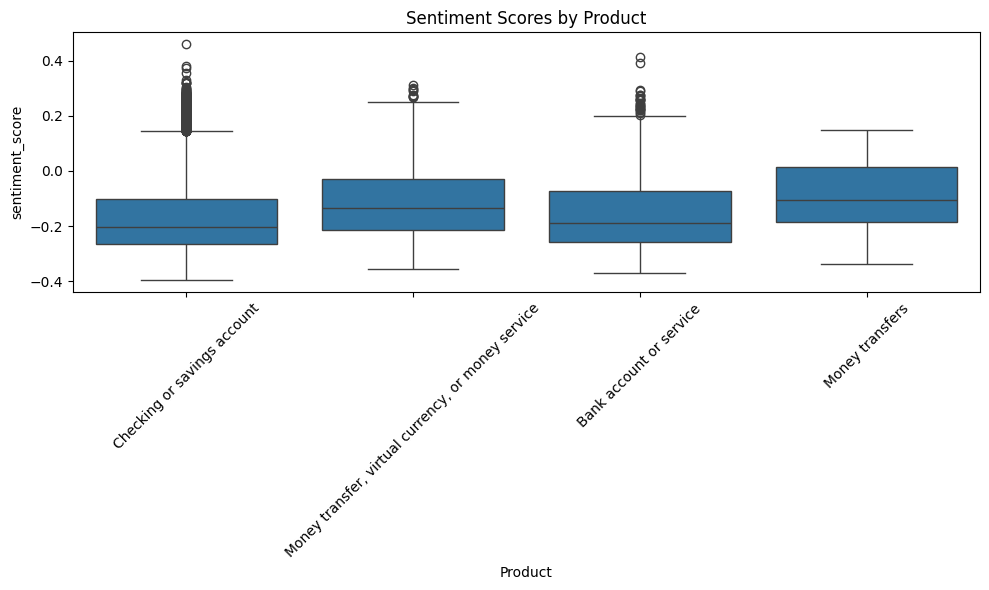

<Figure size 1000x600 with 0 Axes>

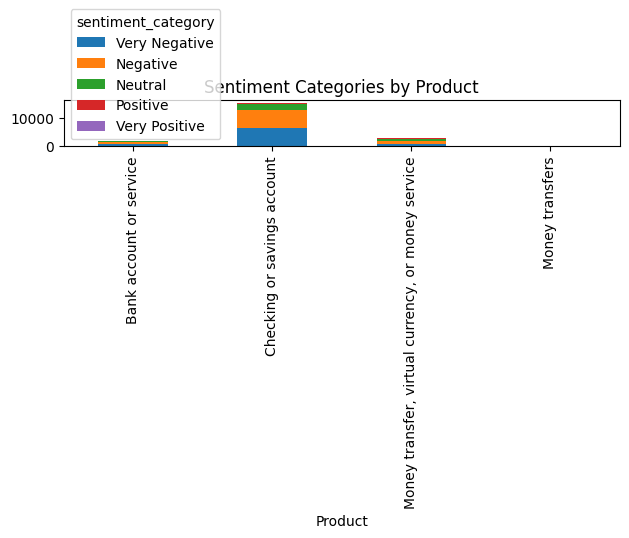

In [73]:
# Example usage:
if __name__ == "__main__":

    # Set date as index if it isn't already
    if 'Date' in df.columns:
        df.set_index(pd.to_datetime(df['Date']), inplace=True)

    # Path to your trained model
    model_path = "/content/finbert_sentiment_regression_model/best_model.pt"

    # Analyze the data
    results, product_summary = analyze_with_finbert(df, model_path)

    # Save results
    results.to_csv("sentiment_analysis_results.csv")
    product_summary.to_csv("sentiment_analysis_by_product.csv")

    # Print summary
    print("\nOverall Sentiment Analysis Summary:")
    print("\nScore Distribution:")
    print(results['sentiment_score'].describe().round(4))

    print("\nCategory Distribution:")
    print(results['sentiment_category'].value_counts())

    print("\nSentiment Analysis by Product:")
    print(product_summary)

    # Plot distributions if desired
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Product', y='sentiment_score', data=results)
        plt.xticks(rotation=45)
        plt.title('Sentiment Scores by Product')
        plt.tight_layout()
        plt.savefig('sentiment_by_product.png')

        plt.figure(figsize=(10, 6))
        results.groupby('Product')['sentiment_category'].value_counts().unstack().plot(kind='bar', stacked=True)
        plt.title('Sentiment Categories by Product')
        plt.tight_layout()
        plt.savefig('sentiment_categories_by_product.png')
    except Exception as e:
        print(f"Error creating plots: {e}")

In [113]:
results = pd.read_csv('sentiment_analysis_results.csv')

In [114]:
results.head()

,Date,Product,Complaint,sentiment_score,sentiment_category
0,2022-08-22,Checking or savings account,On XX/XX/2022 I moved {$500.00} from my XXXX X...,-0.057993,Negative
1,2024-11-25,Checking or savings account,I had XXXX accounts opened on Wells Fargo and ...,-0.328350,Very Negative
2,2023-10-31,Checking or savings account,I was the victim of false charges to my accoun...,-0.279382,Very Negative
3,2022-10-18,Checking or savings account,I received four emails on XX/XX/XXXX about a W...,-0.134244,Negative
4,2023-11-08,Checking or savings account,"On XX/XX/, I reached out to Wells Fargo in reg...",0.050753,Neutral


In [115]:
results = results.set_index(pd.to_datetime(results['Date']))

In [116]:
results = results.sort_index(ascending=True)

In [117]:
results.head()

,Date,Product,Complaint,sentiment_score,sentiment_category
Date,,,,,
2015-03-19,2015-03-19,Bank account or service,On XXXX XXXX around XXXX XXXX I called Wells F...,0.049050,Neutral
2015-03-20,2015-03-20,Bank account or service,"On XXXX XXXX, 2014, I went into a Wells Fargo ...",0.110627,Neutral
2015-03-20,2015-03-20,Bank account or service,My mother XXXX XXXX was a XXXX and has been a ...,-0.201956,Negative
2015-03-21,2015-03-21,Bank account or service,Wells Fargo has recently began charging fees t...,-0.239625,Very Negative
2015-03-22,2015-03-22,Bank account or service,Wells Fargo failed to stop debits from XXXX af...,-0.251414,Very Negative


In [119]:
results = results.drop(['Date', 'Product'], axis=1)

In [120]:
results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20163 entries, 2015-03-19 to 2024-12-24
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Complaint           20163 non-null  object 
 1   sentiment_score     20163 non-null  float64
 2   sentiment_category  20163 non-null  object 
dtypes: float64(1), object(2)
memory usage: 630.1+ KB


In [121]:
results.index = results.index.strftime('%Y-%m')

In [122]:
results.head()

,Complaint,sentiment_score,sentiment_category
Date,,,
2015-03,On XXXX XXXX around XXXX XXXX I called Wells F...,0.049050,Neutral
2015-03,"On XXXX XXXX, 2014, I went into a Wells Fargo ...",0.110627,Neutral
2015-03,My mother XXXX XXXX was a XXXX and has been a ...,-0.201956,Negative
2015-03,Wells Fargo has recently began charging fees t...,-0.239625,Very Negative
2015-03,Wells Fargo failed to stop debits from XXXX af...,-0.251414,Very Negative


In [123]:
results['year_month'] = results.index

In [124]:
results.head()

,Complaint,sentiment_score,sentiment_category,year_month
Date,,,,
2015-03,On XXXX XXXX around XXXX XXXX I called Wells F...,0.049050,Neutral,2015-03
2015-03,"On XXXX XXXX, 2014, I went into a Wells Fargo ...",0.110627,Neutral,2015-03
2015-03,My mother XXXX XXXX was a XXXX and has been a ...,-0.201956,Negative,2015-03
2015-03,Wells Fargo has recently began charging fees t...,-0.239625,Very Negative,2015-03
2015-03,Wells Fargo failed to stop debits from XXXX af...,-0.251414,Very Negative,2015-03


In [126]:
monthly_results = results.groupby([
    results.year_month
]).agg({'sentiment_score': ['mean', 'count']

}).round(4)

In [127]:
monthly_results

sentiment_score      
                      mean count
year_month                      
2015-03            -0.1544    16
2015-04            -0.1558    47
2015-05            -0.1454    58
2015-06            -0.1673    68
2015-07            -0.1713    69
...                    ...   ...
2024-08            -0.1691   401
2024-09            -0.1552   314
2024-10            -0.1613   394
2024-11            -0.1563   268
2024-12            -0.1588   175

[118 rows x 2 columns]

In [128]:
monthly_results.to_csv('monthly_results.csv')